In [1]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.5 MB/s eta 0:00:00


In [2]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

In [3]:
df = pd.read_csv('BNB-USD.csv')

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [5]:
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close).reshape(-1, 1))

In [7]:
# Hàm tạo đặc trưng lag
def create_lagged_features(data, n_lags=1):
    df_lags = pd.DataFrame()
    for i in range(n_lags):
        df_lags[f'lag_{i+1}'] = np.roll(data, shift=i+1)
    df_lags['target'] = data
    return df_lags.iloc[n_lags:]

In [8]:
# Hàm tối ưu hóa sử dụng Optuna
def objective(trial):
    # Gợi ý giá trị cho n_lags và n_estimators
    n_lags = trial.suggest_int('n_lags', 1, 30)                 # Tìm số lượng lag từ 1 đến 30
    n_estimators = trial.suggest_int('n_estimators', 10, 200)   # Tìm số lượng cây từ 10 đến 200

    # Tạo đặc trưng lag
    lagged_data = create_lagged_features(data_scaled.flatten(), n_lags)
    X, y = lagged_data.iloc[:, :-1], lagged_data.iloc[:, -1]

    tscv = TimeSeriesSplit(n_splits=5)
    errors = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)

        errors.append(mean_squared_error(y_test, y_pred))

    return np.mean(errors)

**Tìm kiếm tham số tối ưu**

In [9]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Thử nghiệm 50 lần để tìm giá trị tối ưu

# In ra tham số tối ưu
best_params = study.best_params
print(f'Best parameters: {best_params}')
print(f'Best trial value: {study.best_value}')


[I 2024-06-21 15:13:46,634] A new study created in memory with name: no-name-ccfb5b01-1fe7-4264-824a-a26aaec2a090
[I 2024-06-21 15:13:57,049] Trial 0 finished with value: 0.04715735458262097 and parameters: {'n_lags': 12, 'n_estimators': 180}. Best is trial 0 with value: 0.04715735458262097.
[I 2024-06-21 15:13:59,447] Trial 1 finished with value: 0.045991099888973125 and parameters: {'n_lags': 2, 'n_estimators': 178}. Best is trial 1 with value: 0.045991099888973125.
[I 2024-06-21 15:14:09,116] Trial 2 finished with value: 0.04918951534396747 and parameters: {'n_lags': 24, 'n_estimators': 125}. Best is trial 1 with value: 0.045991099888973125.
[I 2024-06-21 15:14:14,806] Trial 3 finished with value: 0.04716170483284846 and parameters: {'n_lags': 10, 'n_estimators': 158}. Best is trial 1 with value: 0.045991099888973125.
[I 2024-06-21 15:14:26,149] Trial 4 finished with value: 0.04923450181104798 and parameters: {'n_lags': 22, 'n_estimators': 157}. Best is trial 1 with value: 0.0459910

Best parameters: {'n_lags': 3, 'n_estimators': 171}
Best trial value: 0.045980425083672616


**Sử dụng tham số tối ưu để huấn luyện mô hình cuối cùng**

In [10]:
optimal_n_lags = best_params['n_lags']
optimal_n_estimators = best_params['n_estimators']
lagged_data = create_lagged_features(data_scaled.flatten(), optimal_n_lags)

In [11]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_size = int(0.7 * len(lagged_data))
train_data, test_data = lagged_data[:train_size], lagged_data[train_size:]
# Tách các đặc trưng và mục tiêu
X_train, y_train = train_data.iloc[:, :-1], train_data.iloc[:, -1]
X_test, y_test = test_data.iloc[:, :-1], test_data.iloc[:, -1]

In [12]:
# Huấn luyện mô hình Random Forest với các tham số tối ưu
rf_model = RandomForestRegressor(n_estimators=optimal_n_estimators, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=171, random_state=42)

In [13]:
# Dự đoán trên tập kiểm tra
y_pred = rf_model.predict(X_test)

In [14]:
# Chuyển đổi lại dữ liệu về thang đo gốc
y_test_inverse = scaler.inverse_transform(y_test.values.reshape(-1, 1))
y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))

In [15]:
# Tính toán các độ đo lỗi
test_mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)
test_mse = mean_squared_error(y_test_inverse, y_pred_inverse)
test_rmse = np.sqrt(test_mse)

print(f"MAPE on Test dataset: {test_mape:.4f}")
print(f"RMSE on Test dataset: {test_rmse:.4f}")
print(f"MSE on Test dataset: {test_mse:.4f}")

MAPE on Test dataset: 0.0268
RMSE on Test dataset: 13.0528
MSE on Test dataset: 170.3765


In [16]:
# Hàm dự báo tương lai
def forecast_future(model, data, n_lags, n_periods):
    future_forecast = []
    last_values = data[-n_lags:]
    for _ in range(n_periods):
        prediction = model.predict(last_values.reshape(1, -1))[0]
        future_forecast.append(prediction)
        last_values = np.append(last_values[1:], prediction)
    return np.array(future_forecast)

In [17]:
# Dự báo giá trị tương lai
forecast_30_days = forecast_future(rf_model, data_scaled.flatten(), optimal_n_lags, 30)
forecast_60_days = forecast_future(rf_model, data_scaled.flatten(), optimal_n_lags, 60)
forecast_90_days = forecast_future(rf_model, data_scaled.flatten(), optimal_n_lags, 90)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does

In [18]:
# Chuyển đổi dự báo về thang đo gốc
forecast_30_days_inverse = scaler.inverse_transform(forecast_30_days.reshape(-1, 1))
forecast_60_days_inverse = scaler.inverse_transform(forecast_60_days.reshape(-1, 1))
forecast_90_days_inverse = scaler.inverse_transform(forecast_90_days.reshape(-1, 1))

In [19]:
print('Predicted closing prices for the next 30 days:')
print(forecast_30_days_inverse.flatten())

print('Predicted closing prices for the next 60 days:')
print(forecast_60_days_inverse.flatten())

print('Predicted closing prices for the next 90 days:')
print(forecast_90_days_inverse.flatten())

Predicted closing prices for the next 30 days:
[580.09597711 580.11283011 588.63564537 586.04216642 590.1950245
 587.11934046 578.73177691 589.52897913 581.52780923 574.43679958
 584.69580712 585.47059577 582.51441378 592.88711242 585.74155358
 585.93307238 587.28881122 586.48616498 587.40677574 585.50673916
 587.17557921 585.50673916 587.10953561 586.30262761 587.04473662
 586.30262761 587.14025735 586.30262761 587.14025735 586.30262761]
Predicted closing prices for the next 60 days:
[580.09597711 580.11283011 588.63564537 586.04216642 590.1950245
 587.11934046 578.73177691 589.52897913 581.52780923 574.43679958
 584.69580712 585.47059577 582.51441378 592.88711242 585.74155358
 585.93307238 587.28881122 586.48616498 587.40677574 585.50673916
 587.17557921 585.50673916 587.10953561 586.30262761 587.04473662
 586.30262761 587.14025735 586.30262761 587.14025735 586.30262761
 587.14025735 586.30262761 587.14025735 586.30262761 587.14025735
 586.30262761 587.14025735 586.30262761 587.14025

In [20]:
# Tạo trục x cho các dự báo tương lai
index_future = pd.date_range(start=df.index[-1], periods=90, freq='D')
index_next_30_days = index_future[:30]
index_next_60_days = index_future[:60]
index_next_90_days = index_future[:90]

# Tạo trục x cho tập huấn luyện và kiểm tra
train_dates = df.index[:train_size]
test_dates = df.index[train_size:train_size + len(y_test)]
predict_dates_30 = index_next_30_days
predict_dates_60 = index_next_60_days
predict_dates_90 = index_next_90_days

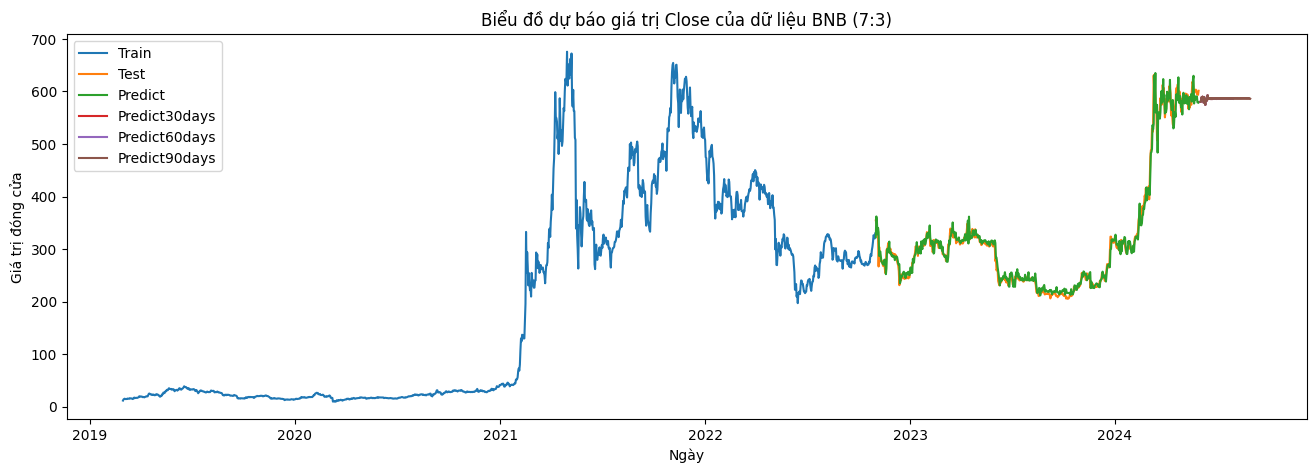

In [21]:
# Vẽ đồ thị cho dự đoán 30, 60, 90 ngày trên cùng một biểu đồ
plt.figure(figsize=(16, 5))

# Đồ thị cho tập huấn luyện
plt.plot(train_dates, scaler.inverse_transform(train_data['target'].values.reshape(-1, 1)),
         color='#1f77b4', linestyle='-', label='Train')

# Đồ thị cho tập kiểm tra
plt.plot(test_dates, y_test_inverse, color='#ff7f0e', linestyle='-', label='Test')
plt.plot(test_dates, y_pred_inverse, color='#2ca02c', linestyle='-', label='Predict')

# Đồ thị cho dự báo 30 ngày
plt.plot(predict_dates_30, forecast_30_days_inverse, color='#d62728', linestyle='-', label='Predict30days')

# Đồ thị cho dự báo 60 ngày
plt.plot(predict_dates_60, forecast_60_days_inverse[:60], color='#9467bd', linestyle='-', label='Predict60days')

# Đồ thị cho dự báo 90 ngày
plt.plot(predict_dates_90, forecast_90_days_inverse[:90], color='#8c564b', linestyle='-', label='Predict90days')

plt.legend()
plt.title("Biểu đồ dự báo giá trị Close của dữ liệu BNB (7:3)")
plt.xlabel("Ngày")
plt.ylabel("Giá trị đóng cửa")
plt.grid(False)
plt.savefig('RandomForest_BNB_73.png')
plt.show()